# Time Series Prediction




![alt text](Sinewave.png "")

## Import packages

In [42]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation

(21,)
(21, 1)


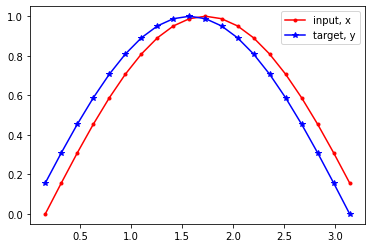

In [15]:
# Length of sequence in one batch
seq_length = 20

# Data points generation
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)

data.resize((seq_length + 1, 1)) #reshaped data to (seq_length+1,1)

x = data[:-1] # all but the last piece of data -> Input sequence = [0,19]
y = data[1:] # all but the first -> target sequence = [1,20]

# display the data
plt.plot(time_steps[1:], x, 'r.-', label='input, x') # x
plt.plot(time_steps[1:], y, 'b*-', label='target, y') # y

plt.legend(loc='best')
plt.show()

## Define RNN Model
![alt text](rnn.png "RNN")
[RNN-Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

##### input_size – The number of expected features in the input x

##### hidden_size – The number of features in the hidden state h

##### num_layers – Number of recurrent layers
##### batch_first – If True, then the input and output tensors are provided as (batch, seq, feature).

In [37]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dims

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0) #Getting batch_size of input
        
        # get RNN outputs (RNN ouput and new hidden state)
        r_out, hidden = self.rnn(x, hidden) #passing intial input and hidden state to rnn layer
        # shape output to be (batch_size*seq_length, hidden_dim) Flattening step- preparing the output of RNN layer to be fed into FC layer
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # pass the shaped ouptut to fc.
        output = self.fc(r_out)
        
        return output, hidden #get final output and hidden state

In [38]:
# decide on hyperparameters
input_size=1
output_size=1
hidden_dim=32 #no. of features generated with RNN layer
n_layers=1 #Not stacking RNN layers

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [39]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [40]:
# train the RNN - parameters(RNN, no.of steps to train,parameter to determine when to print the loss)
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state - at first it will default to all zeros
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # Generating the training data - 20 sine wave values at a time
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1] #Input
        y = data[1:] #Target
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn (takes in input tensor and intial hidden state and predicts output and new hidden state)
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data #will be passed to rnn for next time step in sequence

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.-') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.-') # predictions
            plt.show()
    
    return rnn


Loss:  0.5213862657546997


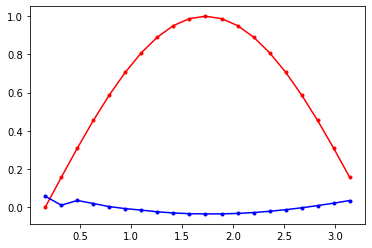

Loss:  0.00901271402835846


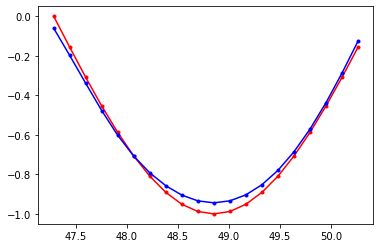

Loss:  0.0018490167567506433


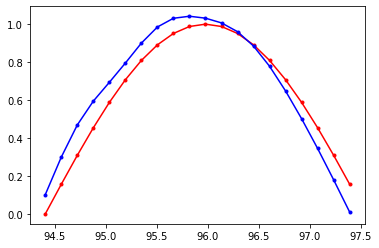

Loss:  0.0010296959662809968


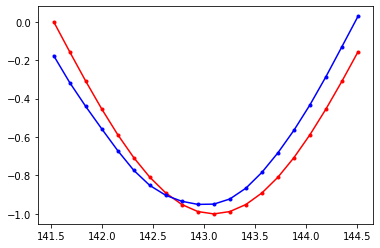

Loss:  6.557805318152532e-05


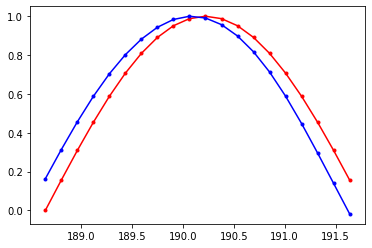

In [41]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)
